In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
from rich.progress import Progress

import json
from fcma.serialization import ProblemSerializer

import fcma
from fcma import Fcma

In [2]:
CSV_FILE = "data_scalability.csv"
df = pd.read_csv(CSV_FILE)

# Add a "correct" column that indicates if the experiment hasn't failed nor timed-out
# looking at the boolean columns failed and timed_out
df["correct"] = ~df["failed"] & ~df["timed_out"]

df

,num,apps,num_families,total_secs,pre_allocation_secs,allocation_secs,partial_ilp_seconds,pre_allocation_lower_bound_cost,cost,min_pred_cost,num_vms,failed,timed_out,problem_file,solution_file,correct
0,0,19,4,102.997288,102.784354,0.208533,101.844404,2.854000,4.00904,2.111152,10,False,False,out_scaling/20250319_121751/problem_e_0_a_19_f...,out_scaling/20250319_121751/sol_e_0_a_19_f_4.json,True
1,1,79,4,602.671426,602.336122,0.315001,600.601655,20.477000,26.71268,17.982808,10,False,True,out_scaling/20250319_121751/problem_e_1_a_79_f...,out_scaling/20250319_121751/sol_e_1_a_79_f_4.json,False
2,2,81,4,255.431388,255.082154,0.328916,253.379364,13.734949,16.54520,10.121383,12,False,False,out_scaling/20250319_121751/problem_e_2_a_81_f...,out_scaling/20250319_121751/sol_e_2_a_81_f_4.json,True
3,3,14,4,3.577984,3.433647,0.141007,3.022496,3.782080,5.52024,2.756135,6,False,False,out_scaling/20250319_121751/problem_e_3_a_14_f...,out_scaling/20250319_121751/sol_e_3_a_14_f_4.json,True
4,4,40,4,43.342211,43.125757,0.205464,42.244027,7.226980,9.27000,5.680695,9,False,False,out_scaling/20250319_121751/problem_e_4_a_40_f...,out_scaling/20250319_121751/sol_e_4_a_40_f_4.json,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,57,4,38.628457,38.337767,0.276640,37.140346,10.889618,13.43296,8.043209,13,False,False,out_scaling/20250319_121751/problem_e_995_a_57...,out_scaling/20250319_121751/sol_e_995_a_57_f_4...,True
996,996,56,2,2.739573,1.077771,1.643957,0.418308,43.715000,51.58944,41.440278,13,False,False,out_scaling/20250319_121751/problem_e_996_a_56...,out_scaling/20250319_121751/sol_e_996_a_56_f_2...,True
997,997,11,4,2.783642,2.706600,0.071022,2.383129,1.529320,2.09800,1.112210,7,False,False,out_scaling/20250319_121751/problem_e_997_a_11...,out_scaling/20250319_121751/sol_e_997_a_11_f_4...,True
998,998,23,1,0.665340,0.203026,0.451318,0.059498,43.104000,53.62800,41.801745,13,False,False,out_scaling/20250319_121751/problem_e_998_a_23...,out_scaling/20250319_121751/sol_e_998_a_23_f_1...,True


In [3]:
# Compute the values of N, M, V and C for each experiment
def get_ics(system) -> set[fcma.InstanceClass]:
    """Get the set of instance classes from the system. This code is optimized to avoid
    unnecessary hashing of the full object."""
    unique_ics = {}
    for _, family in system:
        for ic in family.ics:
            if ic.name not in unique_ics:  # Avoids unnecessary hashing of the full object
                unique_ics[ic.name] = ic
    return set(unique_ics.values())  # Convert dict values to set

def get_number_of_containers(app: fcma.App, problem: Fcma):
    """Returns the average number of containers for each app. It's computed as the
    division of its workload by the average performance of its minimum containers."""

    total_perf = 0
    count = 0
    
    for (system_app, _), perf in problem.system.items():
        if system_app == app:
            total_perf += perf.perf
            count += 1
    
    if count == 0:
        raise ValueError("App not found in the system")
    
    average_perf = total_perf / count
    workload = problem.workloads[app]
    
    # The return value is dimensionless
    return (workload / average_perf).magnitude

def get_avg_cores_containers(system: fcma.System) -> float:
    """Returns the average number of cores of all the minimum containers in the system."""
    total_cores = 0
    count = 0

    for (app, family), perf in system.items():
        total_cores += perf.cores
        count += 1

    return total_cores / count

def get_avg_cores_ics(ics: set[fcma.InstanceClass]):
    """Returns the average number of cores of all the instance classes."""
    total_cores = 0
    count = 0

    for ic in ics:
        total_cores += ic.cores
        count += 1

    return total_cores / count

def get_number_of_nodes(system: fcma.System, container_count: int, ics: set[fcma.InstanceClass]) -> int:
    """Returns the number of containers multiplied by avg_cores_containers/avg_cores_ics"""
    avg_cores_containers = get_avg_cores_containers(system)
    avg_cores_ics = get_avg_cores_ics(ics)

    # The return value is dimensionless
    return (container_count * avg_cores_containers / avg_cores_ics).magnitude

def get_N_M_V_C(problem: Fcma):
    """Get the values of N, M, W and R from an FCMA problem.
    N: number of apps
    M: number of instance classes
    V: number of nodes (VMs)
    C: number of containers"""
    apps = set(a for a, _ in problem.system)
    N = len(apps)

    ics = get_ics(problem.system)
    M = len(ics)

    C = sum(get_number_of_containers(app, problem) for app in apps)

    V = get_number_of_nodes(problem.system, C, ics)

    return N, M, V, C

In [4]:
# If the file with the extended data (N, M, V and C) already exists, load it. Otherwise,
# create it.
CSV_EXTENDED_FILE = "data_scalability_N_M_V_C.csv"
try:
    df = pd.read_csv(CSV_EXTENDED_FILE)
    print("File already exists. Loading it.")
except FileNotFoundError:
    print("File not found. Creating it from scratch.")

    # For all the rows in df, we will load the json file and get the values of N, M, V and C
    # and put them on the dataframe
    df["N"] = None
    df["M"] = None
    df["V"] = None
    df["C"] = None

    with Progress() as progress:
        # Add a task to the progress bar
        task = progress.add_task("Processing...", total=len(df))

        for i, row in df.iterrows():
            progress.update(task, advance=1)
            with open(row["problem_file"]) as f:
                data = json.load(f)

            problem = ProblemSerializer.from_dict(data)
            N, M, V, C = get_N_M_V_C(problem)
            df.at[i, "N"] = N
            df.at[i, "M"] = M
            df.at[i, "V"] = V
            df.at[i, "C"] = C

    # Save the dataframe to a csv file
    df.to_csv(CSV_EXTENDED_FILE, index=False)

File already exists. Loading it.


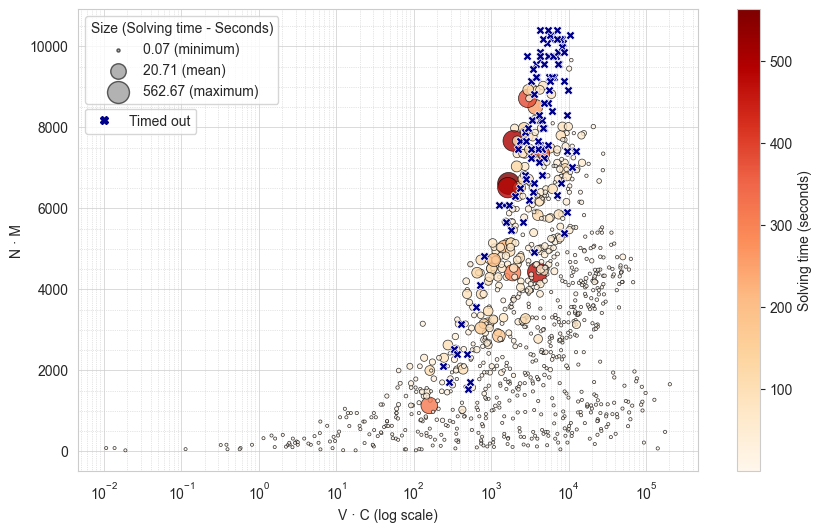

In [5]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))

df_correct = df[df.correct]
x_values = df_correct['V'] * df_correct['C']
y_values = df_correct['N'] * df_correct['M']

# Avoid log issues by replacing zero with a small positive value
x_values = np.where(x_values == 0, 1, x_values) 

scatter = sns.scatterplot(
    x=x_values, 
    y=y_values, 
    hue=df_correct['total_secs'], 
    palette="OrRd", 
    size=df_correct['total_secs'], 
    sizes=(5, 250),  # Ensure small values are still visible
    edgecolor="black",  # Outline for clarity
    linewidth=0.5,  # Thin border around points
    alpha=0.8  # Reduce transparency issues
)

# Add a color bar
norm = plt.Normalize(df_correct['total_secs'].min(), df_correct['total_secs'].max())
sm = plt.cm.ScalarMappable(cmap="OrRd", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=scatter.axes, label='Solving time (seconds)')

# Add a red "X" marker for missing data with a color that stands out
nan_data = df[df['total_secs'].isna()]
sns.scatterplot(
    x=nan_data['V'] * nan_data['C'], 
    y=nan_data['N'] * nan_data['M'], 
    color="#DC143C",
    marker="X",
    s=50,  # Fixed size
    label="No solution"
)

# Add a blue "X" marker for timed out experiments that didn't failed
df_timeout = df[df.timed_out & ~df.failed]
sns.scatterplot(
    x=df_timeout['V'] * df_timeout['C'], 
    y=df_timeout['N'] * df_timeout['M'], 
    color="#00008B",  # Dark blue color
    marker="X",
    s=40,  # Fixed size
    label="Timed out"
)

# Create a custom legend for sizes
handles, labels = scatter.get_legend_handles_labels()
size_values = [df_correct['total_secs'].min(), df_correct['total_secs'].mean(), df_correct['total_secs'].max()]
descriptions = ["minimum", "mean", "maximum"]
size_labels = [f"{value:.2f} ({desc})" for value, desc in zip(size_values, descriptions)]
size_handles = [plt.scatter([], [], s=size, color='gray', alpha=0.6, edgecolor="black") for size in [5, 125, 250]]
size_legend = plt.legend(size_handles, size_labels, title="Size (Solving time - Seconds)", loc="upper left")

plt.gca().add_artist(size_legend)

# Add legend for the "X" markers
x_marker_handles = [
    # plt.Line2D([], [], color="#DC143C", marker='X', linestyle='None', markersize=5, label='No solution'),
    plt.Line2D([], [], color="#00008B", marker='X', linestyle='None', markersize=6, label='Timed out')
]
plt.legend(handles=x_marker_handles, loc="upper left", bbox_to_anchor=(0, 0.8))

plt.xscale("log")

plt.xlabel("V · C (log scale)")
plt.ylabel("N · M")
# plt.title("Scaling of FCMA")

plt.minorticks_on()
plt.gca().xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))  # Ensure minor ticks follow log scale
plt.grid(True, which="both", linestyle="-", linewidth=0.5)
plt.grid(True, which="minor", linestyle=":", linewidth=0.5)  # Different style for minor grid

# Save the figure
plt.savefig("scaling.png", dpi=600, bbox_inches="tight")

plt.show()

In [6]:
# Compute the product M * N
df["M*N"] = df["M"] * df["N"]

# Define bins
bin_width = 1000
bin_range = (0, df["M*N"].max())
bins = np.arange(bin_range[0], bin_range[1] + bin_width, bin_width)
labels = [f"{{[{bins[i]}, {bins[i+1]})}}" for i in range(len(bins)-1)]

# Bin the data
df["bin"] = pd.cut(df["M*N"], bins=bins, labels=labels, right=False)

# Compute the required statistics
summary = df.groupby("bin", observed=False).agg(
    solved_percentage=("correct", lambda x: 100 * x.mean()),  # Mean gives fraction of correct
    num_problems=("correct", "count")
).reset_index()

# Rename columns
summary.columns = ["N · M", "Solved (%)", "Number of problems generated"]

# Display the table

print(summary.to_latex(index=False, float_format="%.2f", escape=False, column_format="lrr"))


\begin{tabular}{lrr}
\toprule
N · M & Solved (%) & Number of problems generated \\
\midrule
{[0, 1000)} & 100.00 & 217 \\
{[1000, 2000)} & 97.92 & 144 \\
{[2000, 3000)} & 96.23 & 106 \\
{[3000, 4000)} & 98.39 & 124 \\
{[4000, 5000)} & 97.86 & 140 \\
{[5000, 6000)} & 93.24 & 74 \\
{[6000, 7000)} & 79.03 & 62 \\
{[7000, 8000)} & 68.25 & 63 \\
{[8000, 9000)} & 57.14 & 28 \\
{[9000, 10000)} & 11.11 & 27 \\
{[10000, 11000)} & 6.67 & 15 \\
\bottomrule
\end{tabular}

